In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms import v2
from PIL import Image

In [2]:
!git clone "https://github.com/Bhavnoor-Coders-1010/DeepFakeBCS" deepfake

class DataDeepFake(Dataset):
    def __init__(self):
        self.fakeImagesLocation = "./deepfake/faketrain/"
        self.realImagesLocation = "./deepfake/realtrain/"
        self.fake = os.listdir(self.fakeImagesLocation)
        self.real = os.listdir(self.realImagesLocation)
        self.basic = v2.Compose([v2.Resize((224,224)),v2.ToTensor()])
        self.t0 = v2.Resize((224,224))
        self.t1 = v2.RandomHorizontalFlip(p=0.5)
        self.t2 = v2.RandomVerticalFlip(p=0.5)
        self.t3 = v2.RandomAffine(degrees=(-30, 30), shear=(0.75, 1.25, 0.75, 1.25))
        self.t4 = v2.ColorJitter(brightness=(0.75, 1.25), contrast=0, saturation=0, hue=0)
        self.tFinal = v2.Compose([self.t1, self.t2, self.t3, self.t4, self.t0, v2.Resize((224,224)), v2.ToTensor()])
    def __len__(self):
        return len(self.fake) + len(self.real)
    def __getitem__(self, idx):
        if(idx>=len(self.fake)+(len(self.real)//2)):
            img = Image.open(self.realImagesLocation+self.real[idx%len(self.fake)])
            img.resize((224, 224))
            img = self.tFinal(img)
            return img, torch.Tensor([0])
        elif(idx>=len(self.fake)):
            img = Image.open(self.realImagesLocation+self.real[idx%len(self.fake)])
            img.resize((224, 224))
            img = self.basic(img)
            return img, torch.Tensor([0])
        elif(idx>=len(self.fake)//2):
            img = Image.open(self.fakeImagesLocation+self.fake[idx])
            img.resize((224, 224))
            img = self.tFinal(img)
            return img, torch.Tensor([1])
        else:
            img = Image.open(self.fakeImagesLocation+self.fake[idx])
            img.resize((224, 224))
            img = self.basic(img)
            return img, torch.Tensor([1])
dataset = DataDeepFake()

Cloning into 'deepfake'...
remote: Enumerating objects: 26814, done.
remote: Counting objects: 100% (7172/7172), done.
remote: Compressing objects: 100% (7168/7168), done.
remote: Total 26814 (delta 3), reused 7170 (delta 1), pack-reused 19642 (from 1)
Receiving objects: 100% (26814/26814), 246.87 MiB | 20.00 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (27059/27059), done.


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:

# Split metadata into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)


# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


9971


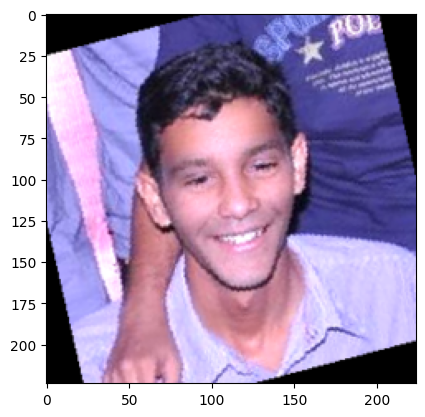

In [4]:
imageNumber = np.random.randint(0,19000)
plt.imshow(dataset[imageNumber][0].permute(1,2,0))
print(imageNumber)

In [5]:
class DeepfakeNet(nn.Module):
    def __init__(self):
        super(DeepfakeNet, self).__init__()
#         self.drp = nn.Dropout(0.4)#------------------------------------------------------------------------------------------------------------------------
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layers = nn.ModuleList([Bottleneck(64, 256, first=True)])
        self.out_size = [256,512,1024,2048]
        self.blocks = [1,2,2,1]
        for i in range(len(self.out_size)):
            if i > 0:
                self.layers.append(Bottleneck(self.out_size[i-1], self.out_size[i], 2))
            for extraLayers in range(self.blocks[i]-1):
                self.layers.append(Bottleneck(self.out_size[i], self.out_size[i]))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 1)
        
        
        
    # def _make_layer(self, in_channels, out_channels, blocks):
    #     layers = []
    #     for _ in range(blocks):                
    #         layers.append(Bottleneck(in_channels, out_channels))
    #     return nn.Sequential(*layers)

    def forward(self, x):
#         x = self.drp(x)#------------------------------------------------------------------------------------------------------------------------------------
        x = self.conv1(x)
        x = self.maxpool(x)
        for layer in self.layers:
            x = layer(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [6]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, first=False):
        super(Bottleneck, self).__init__()
        mid_channels = out_channels//2
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, kernel_size=3, padding=1, groups=32, stride=stride)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = stride == 2 or first 
        if self.downsample:
            self.changeInputC2D = nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
            self.changeInputBn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample:
            residual = self.changeInputC2D(residual)
            residual = self.changeInputBn(residual)
        out = torch.add(out, residual)
        out = self.relu(out)
        return out



In [7]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Calculate average loss
    avg_loss = running_loss / len(dataloader)
    training_loss.append(avg_loss)
    return avg_loss

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)

            # Accumulate loss
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.round(outputs)
            # print(outputs)
            # print(predicted)
            # print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = val_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    validation_loss.append(avg_loss)
    validation_acc.append(accuracy)
    return avg_loss, accuracy

In [9]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model, optimizer, and criterion
model = DeepfakeNet()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()  # Assuming binary classification (1 output unit)

# Move model to device
model.to(device)


DeepfakeNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (changeInputC2D): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (changeInputBn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 256

In [10]:
!pip install torchsummary
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3          [-1, 128, 56, 56]           8,320
       BatchNorm2d-4          [-1, 128, 56, 56]             256
              ReLU-5          [-1, 128, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]           4,736
       BatchNorm2d-7          [-1, 128, 56, 56]             256
              ReLU-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]          33,024
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
       Bottleneck-14          [-1, 256,

In [11]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 200

In [12]:
training_loss = []
validation_loss = []
validation_acc = []
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")


# Optionally, save your model
# torch.save(model.state_dict(), 'model.pth')

Epoch 1/200


Training Loss: 0.2155 | Validation Loss: 0.1989 | Validation Accuracy: 70.44%
Epoch 2/200


Training Loss: 0.1778 | Validation Loss: 0.1932 | Validation Accuracy: 72.65%
Epoch 3/200


Training Loss: 0.1561 | Validation Loss: 0.1936 | Validation Accuracy: 72.07%
Epoch 4/200


Training Loss: 0.1330 | Validation Loss: 0.1862 | Validation Accuracy: 72.20%
Epoch 5/200


Training Loss: 0.1127 | Validation Loss: 0.1725 | Validation Accuracy: 75.09%
Epoch 6/200


Training Loss: 0.0929 | Validation Loss: 0.1778 | Validation Accuracy: 74.28%
Epoch 7/200


Training Loss: 0.0767 | Validation Loss: 0.1830 | Validation Accuracy: 73.30%
Epoch 8/200


Training Loss: 0.0630 | Validation Loss: 0.1761 | Validation Accuracy: 75.11%
Epoch 9/200


Training Loss: 0.0537 | Validation Loss: 0.1800 | Validation Accuracy: 75.24%
Epoch 10/200


Training Loss: 0.0444 | Validation Loss: 0.1781 | Validation Accuracy: 74.81%
Epoch 11/200


Training Loss: 0.0390 | Validation Loss: 0.2117 | Validation Accuracy: 69.49%
Epoch 12/200


Training Loss: 0.0342 | Validation Loss: 0.1879 | Validation Accuracy: 74.26%
Epoch 13/200


Training Loss: 0.0315 | Validation Loss: 0.1800 | Validation Accuracy: 74.91%
Epoch 14/200


Training Loss: 0.0297 | Validation Loss: 0.1772 | Validation Accuracy: 74.11%
Epoch 15/200


Training Loss: 0.0280 | Validation Loss: 0.1754 | Validation Accuracy: 75.09%
Epoch 16/200


Training Loss: 0.0267 | Validation Loss: 0.1763 | Validation Accuracy: 74.74%
Epoch 17/200


Training Loss: 0.0257 | Validation Loss: 0.1776 | Validation Accuracy: 75.09%
Epoch 18/200


Training Loss: 0.0259 | Validation Loss: 0.1875 | Validation Accuracy: 72.80%
Epoch 19/200


Training Loss: 0.0230 | Validation Loss: 0.1722 | Validation Accuracy: 76.14%
Epoch 20/200


Training Loss: 0.0233 | Validation Loss: 0.1930 | Validation Accuracy: 72.75%
Epoch 21/200


Training Loss: 0.0229 | Validation Loss: 0.1729 | Validation Accuracy: 75.67%
Epoch 22/200


Training Loss: 0.0220 | Validation Loss: 0.1764 | Validation Accuracy: 74.84%
Epoch 23/200


Training Loss: 0.0215 | Validation Loss: 0.1791 | Validation Accuracy: 73.86%
Epoch 24/200


Training Loss: 0.0213 | Validation Loss: 0.1945 | Validation Accuracy: 73.46%
Epoch 25/200


Training Loss: 0.0196 | Validation Loss: 0.2023 | Validation Accuracy: 70.54%
Epoch 26/200


Training Loss: 0.0197 | Validation Loss: 0.1687 | Validation Accuracy: 76.12%
Epoch 27/200


Training Loss: 0.0199 | Validation Loss: 0.1632 | Validation Accuracy: 77.07%
Epoch 28/200


Training Loss: 0.0190 | Validation Loss: 0.1649 | Validation Accuracy: 76.67%
Epoch 29/200


Training Loss: 0.0193 | Validation Loss: 0.1664 | Validation Accuracy: 76.02%
Epoch 30/200


Training Loss: 0.0186 | Validation Loss: 0.1616 | Validation Accuracy: 77.02%
Epoch 31/200


Training Loss: 0.0180 | Validation Loss: 0.1639 | Validation Accuracy: 77.27%
Epoch 32/200


Training Loss: 0.0171 | Validation Loss: 0.1903 | Validation Accuracy: 73.03%
Epoch 33/200


Training Loss: 0.0174 | Validation Loss: 0.1868 | Validation Accuracy: 72.78%
Epoch 34/200


Training Loss: 0.0171 | Validation Loss: 0.1621 | Validation Accuracy: 77.10%
Epoch 35/200


Training Loss: 0.0170 | Validation Loss: 0.1612 | Validation Accuracy: 76.90%
Epoch 36/200


Training Loss: 0.0177 | Validation Loss: 0.1727 | Validation Accuracy: 74.94%
Epoch 37/200


Training Loss: 0.0168 | Validation Loss: 0.1628 | Validation Accuracy: 76.80%
Epoch 38/200


Training Loss: 0.0165 | Validation Loss: 0.1596 | Validation Accuracy: 77.88%
Epoch 39/200


Training Loss: 0.0166 | Validation Loss: 0.1586 | Validation Accuracy: 77.95%
Epoch 40/200


Training Loss: 0.0160 | Validation Loss: 0.1731 | Validation Accuracy: 74.94%
Epoch 41/200


Training Loss: 0.0155 | Validation Loss: 0.1579 | Validation Accuracy: 77.77%
Epoch 42/200


Training Loss: 0.0152 | Validation Loss: 0.1729 | Validation Accuracy: 74.76%
Epoch 43/200


Training Loss: 0.0151 | Validation Loss: 0.1600 | Validation Accuracy: 77.32%
Epoch 44/200


Training Loss: 0.0150 | Validation Loss: 0.1599 | Validation Accuracy: 77.30%
Epoch 45/200


Training Loss: 0.0150 | Validation Loss: 0.1556 | Validation Accuracy: 78.50%
Epoch 46/200


Training Loss: 0.0134 | Validation Loss: 0.1567 | Validation Accuracy: 78.15%
Epoch 47/200


Training Loss: 0.0145 | Validation Loss: 0.1555 | Validation Accuracy: 78.33%
Epoch 48/200


Training Loss: 0.0137 | Validation Loss: 0.1598 | Validation Accuracy: 77.22%
Epoch 49/200


Training Loss: 0.0139 | Validation Loss: 0.1626 | Validation Accuracy: 77.57%
Epoch 50/200


Training Loss: 0.0135 | Validation Loss: 0.1706 | Validation Accuracy: 75.74%
Epoch 51/200


Training Loss: 0.0135 | Validation Loss: 0.1635 | Validation Accuracy: 76.54%
Epoch 52/200


Training Loss: 0.0133 | Validation Loss: 0.1543 | Validation Accuracy: 78.20%
Epoch 53/200


Training Loss: 0.0126 | Validation Loss: 0.1539 | Validation Accuracy: 78.68%
Epoch 54/200


Training Loss: 0.0123 | Validation Loss: 0.1517 | Validation Accuracy: 79.26%
Epoch 55/200


Training Loss: 0.0123 | Validation Loss: 0.1580 | Validation Accuracy: 77.88%
Epoch 56/200


Training Loss: 0.0132 | Validation Loss: 0.1533 | Validation Accuracy: 78.78%
Epoch 57/200


Training Loss: 0.0126 | Validation Loss: 0.1524 | Validation Accuracy: 79.08%
Epoch 58/200


Training Loss: 0.0122 | Validation Loss: 0.1534 | Validation Accuracy: 78.30%
Epoch 59/200


Training Loss: 0.0127 | Validation Loss: 0.1507 | Validation Accuracy: 79.43%
Epoch 60/200


Training Loss: 0.0124 | Validation Loss: 0.1657 | Validation Accuracy: 76.97%
Epoch 61/200


Training Loss: 0.0116 | Validation Loss: 0.1594 | Validation Accuracy: 77.35%
Epoch 62/200


Training Loss: 0.0112 | Validation Loss: 0.1557 | Validation Accuracy: 78.50%
Epoch 63/200


Training Loss: 0.0117 | Validation Loss: 0.1486 | Validation Accuracy: 79.68%
Epoch 64/200


Training Loss: 0.0119 | Validation Loss: 0.1600 | Validation Accuracy: 77.67%
Epoch 65/200


Training Loss: 0.0114 | Validation Loss: 0.1508 | Validation Accuracy: 79.26%
Epoch 66/200


Training Loss: 0.0114 | Validation Loss: 0.1524 | Validation Accuracy: 78.65%
Epoch 67/200


Training Loss: 0.0106 | Validation Loss: 0.1514 | Validation Accuracy: 79.23%
Epoch 68/200


Training Loss: 0.0112 | Validation Loss: 0.1507 | Validation Accuracy: 79.16%
Epoch 69/200


Training Loss: 0.0111 | Validation Loss: 0.1486 | Validation Accuracy: 80.01%
Epoch 70/200


Training Loss: 0.0104 | Validation Loss: 0.1494 | Validation Accuracy: 79.23%
Epoch 71/200


Training Loss: 0.0105 | Validation Loss: 0.1483 | Validation Accuracy: 79.68%
Epoch 72/200


Training Loss: 0.0105 | Validation Loss: 0.1481 | Validation Accuracy: 79.63%
Epoch 73/200


Training Loss: 0.0101 | Validation Loss: 0.1502 | Validation Accuracy: 79.66%
Epoch 74/200


Training Loss: 0.0111 | Validation Loss: 0.1482 | Validation Accuracy: 79.68%
Epoch 75/200


Training Loss: 0.0100 | Validation Loss: 0.1550 | Validation Accuracy: 78.65%
Epoch 76/200


Training Loss: 0.0107 | Validation Loss: 0.1472 | Validation Accuracy: 79.76%
Epoch 77/200


Training Loss: 0.0098 | Validation Loss: 0.1474 | Validation Accuracy: 80.14%
Epoch 78/200


Training Loss: 0.0097 | Validation Loss: 0.1479 | Validation Accuracy: 80.21%
Epoch 79/200


Training Loss: 0.0100 | Validation Loss: 0.1515 | Validation Accuracy: 79.38%
Epoch 80/200


Training Loss: 0.0100 | Validation Loss: 0.1524 | Validation Accuracy: 79.26%
Epoch 81/200


Training Loss: 0.0103 | Validation Loss: 0.1452 | Validation Accuracy: 80.31%
Epoch 82/200


Training Loss: 0.0095 | Validation Loss: 0.1456 | Validation Accuracy: 80.11%
Epoch 83/200


Training Loss: 0.0096 | Validation Loss: 0.1460 | Validation Accuracy: 80.39%
Epoch 84/200


Training Loss: 0.0099 | Validation Loss: 0.1448 | Validation Accuracy: 80.09%
Epoch 85/200


Training Loss: 0.0091 | Validation Loss: 0.1469 | Validation Accuracy: 80.04%
Epoch 86/200


Training Loss: 0.0100 | Validation Loss: 0.1474 | Validation Accuracy: 79.83%
Epoch 87/200


Training Loss: 0.0095 | Validation Loss: 0.1501 | Validation Accuracy: 78.68%
Epoch 88/200


Training Loss: 0.0091 | Validation Loss: 0.1479 | Validation Accuracy: 79.43%
Epoch 89/200


Training Loss: 0.0093 | Validation Loss: 0.1499 | Validation Accuracy: 79.31%
Epoch 90/200


Training Loss: 0.0091 | Validation Loss: 0.1451 | Validation Accuracy: 80.16%
Epoch 91/200


Training Loss: 0.0090 | Validation Loss: 0.1468 | Validation Accuracy: 80.11%
Epoch 92/200


Training Loss: 0.0092 | Validation Loss: 0.1570 | Validation Accuracy: 77.90%
Epoch 93/200


Training Loss: 0.0086 | Validation Loss: 0.1440 | Validation Accuracy: 80.91%
Epoch 94/200


Training Loss: 0.0085 | Validation Loss: 0.1424 | Validation Accuracy: 80.61%
Epoch 95/200


Training Loss: 0.0084 | Validation Loss: 0.1428 | Validation Accuracy: 80.89%
Epoch 96/200


Training Loss: 0.0085 | Validation Loss: 0.1442 | Validation Accuracy: 80.49%
Epoch 97/200


Training Loss: 0.0086 | Validation Loss: 0.1437 | Validation Accuracy: 80.79%
Epoch 98/200


Training Loss: 0.0083 | Validation Loss: 0.1499 | Validation Accuracy: 79.11%
Epoch 99/200


Training Loss: 0.0087 | Validation Loss: 0.1428 | Validation Accuracy: 81.12%
Epoch 100/200


Training Loss: 0.0083 | Validation Loss: 0.1431 | Validation Accuracy: 81.01%
Epoch 101/200


Training Loss: 0.0077 | Validation Loss: 0.1433 | Validation Accuracy: 80.81%
Epoch 102/200


Training Loss: 0.0080 | Validation Loss: 0.1424 | Validation Accuracy: 81.04%
Epoch 103/200


Training Loss: 0.0086 | Validation Loss: 0.1457 | Validation Accuracy: 80.16%
Epoch 104/200


Training Loss: 0.0082 | Validation Loss: 0.1461 | Validation Accuracy: 80.36%
Epoch 105/200


Training Loss: 0.0074 | Validation Loss: 0.1434 | Validation Accuracy: 80.69%
Epoch 106/200


Training Loss: 0.0077 | Validation Loss: 0.1462 | Validation Accuracy: 79.71%
Epoch 107/200


Training Loss: 0.0075 | Validation Loss: 0.1439 | Validation Accuracy: 81.27%
Epoch 108/200


Training Loss: 0.0078 | Validation Loss: 0.1420 | Validation Accuracy: 81.24%
Epoch 109/200


Training Loss: 0.0077 | Validation Loss: 0.1437 | Validation Accuracy: 80.51%
Epoch 110/200


Training Loss: 0.0071 | Validation Loss: 0.1425 | Validation Accuracy: 81.06%
Epoch 111/200


Training Loss: 0.0078 | Validation Loss: 0.1417 | Validation Accuracy: 80.81%
Epoch 112/200


Training Loss: 0.0076 | Validation Loss: 0.1444 | Validation Accuracy: 80.64%
Epoch 113/200


Training Loss: 0.0072 | Validation Loss: 0.1400 | Validation Accuracy: 81.57%
Epoch 114/200


Training Loss: 0.0078 | Validation Loss: 0.1398 | Validation Accuracy: 80.86%
Epoch 115/200


Training Loss: 0.0068 | Validation Loss: 0.1407 | Validation Accuracy: 81.06%
Epoch 116/200


Training Loss: 0.0071 | Validation Loss: 0.1446 | Validation Accuracy: 80.76%
Epoch 117/200


Training Loss: 0.0071 | Validation Loss: 0.1421 | Validation Accuracy: 81.09%
Epoch 118/200


Training Loss: 0.0069 | Validation Loss: 0.1407 | Validation Accuracy: 81.01%
Epoch 119/200


Training Loss: 0.0069 | Validation Loss: 0.1420 | Validation Accuracy: 80.16%
Epoch 120/200


Training Loss: 0.0071 | Validation Loss: 0.1413 | Validation Accuracy: 81.09%
Epoch 121/200


Training Loss: 0.0070 | Validation Loss: 0.1425 | Validation Accuracy: 80.69%
Epoch 122/200


Training Loss: 0.0066 | Validation Loss: 0.1446 | Validation Accuracy: 80.56%
Epoch 123/200


Training Loss: 0.0066 | Validation Loss: 0.1391 | Validation Accuracy: 81.59%
Epoch 124/200


Training Loss: 0.0068 | Validation Loss: 0.1494 | Validation Accuracy: 78.93%
Epoch 125/200


Training Loss: 0.0069 | Validation Loss: 0.1388 | Validation Accuracy: 80.99%
Epoch 126/200


Training Loss: 0.0069 | Validation Loss: 0.1459 | Validation Accuracy: 79.98%
Epoch 127/200


Training Loss: 0.0065 | Validation Loss: 0.1398 | Validation Accuracy: 81.47%
Epoch 128/200


Training Loss: 0.0061 | Validation Loss: 0.1401 | Validation Accuracy: 80.59%
Epoch 129/200


Training Loss: 0.0064 | Validation Loss: 0.1396 | Validation Accuracy: 81.19%
Epoch 130/200


Training Loss: 0.0070 | Validation Loss: 0.1385 | Validation Accuracy: 81.19%
Epoch 131/200


Training Loss: 0.0068 | Validation Loss: 0.1410 | Validation Accuracy: 80.96%
Epoch 132/200


Training Loss: 0.0064 | Validation Loss: 0.1378 | Validation Accuracy: 81.67%
Epoch 133/200


Training Loss: 0.0069 | Validation Loss: 0.1394 | Validation Accuracy: 80.99%
Epoch 134/200


Training Loss: 0.0059 | Validation Loss: 0.1369 | Validation Accuracy: 81.59%
Epoch 135/200


Training Loss: 0.0059 | Validation Loss: 0.1372 | Validation Accuracy: 81.69%
Epoch 136/200


Training Loss: 0.0058 | Validation Loss: 0.1376 | Validation Accuracy: 81.74%
Epoch 137/200


Training Loss: 0.0058 | Validation Loss: 0.1453 | Validation Accuracy: 80.44%
Epoch 138/200


Training Loss: 0.0062 | Validation Loss: 0.1379 | Validation Accuracy: 81.84%
Epoch 139/200


Training Loss: 0.0060 | Validation Loss: 0.1372 | Validation Accuracy: 81.62%
Epoch 140/200


Training Loss: 0.0054 | Validation Loss: 0.1449 | Validation Accuracy: 80.16%
Epoch 141/200


Training Loss: 0.0060 | Validation Loss: 0.1365 | Validation Accuracy: 81.62%
Epoch 142/200


Training Loss: 0.0062 | Validation Loss: 0.1372 | Validation Accuracy: 81.69%
Epoch 143/200


Training Loss: 0.0056 | Validation Loss: 0.1380 | Validation Accuracy: 81.72%
Epoch 144/200


Training Loss: 0.0058 | Validation Loss: 0.1380 | Validation Accuracy: 81.64%
Epoch 145/200


Training Loss: 0.0056 | Validation Loss: 0.1366 | Validation Accuracy: 81.84%
Epoch 146/200


Training Loss: 0.0057 | Validation Loss: 0.1398 | Validation Accuracy: 81.29%
Epoch 147/200


Training Loss: 0.0054 | Validation Loss: 0.1371 | Validation Accuracy: 81.72%
Epoch 148/200


Training Loss: 0.0056 | Validation Loss: 0.1382 | Validation Accuracy: 81.72%
Epoch 149/200


Training Loss: 0.0055 | Validation Loss: 0.1366 | Validation Accuracy: 82.02%
Epoch 150/200


Training Loss: 0.0054 | Validation Loss: 0.1377 | Validation Accuracy: 81.84%
Epoch 151/200


Training Loss: 0.0054 | Validation Loss: 0.1363 | Validation Accuracy: 82.02%
Epoch 152/200


Training Loss: 0.0052 | Validation Loss: 0.1437 | Validation Accuracy: 80.54%
Epoch 153/200


Training Loss: 0.0051 | Validation Loss: 0.1401 | Validation Accuracy: 81.62%
Epoch 154/200


Training Loss: 0.0050 | Validation Loss: 0.1382 | Validation Accuracy: 81.67%
Epoch 155/200


Training Loss: 0.0050 | Validation Loss: 0.1355 | Validation Accuracy: 81.84%
Epoch 156/200


Training Loss: 0.0049 | Validation Loss: 0.1373 | Validation Accuracy: 81.97%
Epoch 157/200


Training Loss: 0.0050 | Validation Loss: 0.1362 | Validation Accuracy: 82.07%
Epoch 158/200


Training Loss: 0.0046 | Validation Loss: 0.1363 | Validation Accuracy: 81.89%
Epoch 159/200


Training Loss: 0.0046 | Validation Loss: 0.1361 | Validation Accuracy: 81.99%
Epoch 160/200


Training Loss: 0.0051 | Validation Loss: 0.1358 | Validation Accuracy: 81.74%
Epoch 161/200


Training Loss: 0.0046 | Validation Loss: 0.1362 | Validation Accuracy: 81.92%
Epoch 162/200


Training Loss: 0.0047 | Validation Loss: 0.1355 | Validation Accuracy: 82.37%
Epoch 163/200


Training Loss: 0.0045 | Validation Loss: 0.1395 | Validation Accuracy: 81.12%
Epoch 164/200


Training Loss: 0.0046 | Validation Loss: 0.1372 | Validation Accuracy: 81.54%
Epoch 165/200


Training Loss: 0.0046 | Validation Loss: 0.1355 | Validation Accuracy: 82.65%
Epoch 166/200


Training Loss: 0.0043 | Validation Loss: 0.1349 | Validation Accuracy: 82.35%
Epoch 167/200


Training Loss: 0.0045 | Validation Loss: 0.1347 | Validation Accuracy: 82.22%
Epoch 168/200


Training Loss: 0.0045 | Validation Loss: 0.1342 | Validation Accuracy: 82.50%
Epoch 169/200


Training Loss: 0.0045 | Validation Loss: 0.1344 | Validation Accuracy: 81.99%
Epoch 170/200


Training Loss: 0.0046 | Validation Loss: 0.1365 | Validation Accuracy: 81.87%
Epoch 171/200


Training Loss: 0.0043 | Validation Loss: 0.1346 | Validation Accuracy: 82.09%
Epoch 172/200


Training Loss: 0.0046 | Validation Loss: 0.1363 | Validation Accuracy: 81.42%
Epoch 173/200


Training Loss: 0.0043 | Validation Loss: 0.1375 | Validation Accuracy: 81.69%
Epoch 174/200


Training Loss: 0.0041 | Validation Loss: 0.1380 | Validation Accuracy: 81.22%
Epoch 175/200


Training Loss: 0.0041 | Validation Loss: 0.1337 | Validation Accuracy: 82.17%
Epoch 176/200


Training Loss: 0.0043 | Validation Loss: 0.1352 | Validation Accuracy: 81.82%
Epoch 177/200


Training Loss: 0.0040 | Validation Loss: 0.1378 | Validation Accuracy: 81.92%
Epoch 178/200


Training Loss: 0.0040 | Validation Loss: 0.1374 | Validation Accuracy: 81.39%
Epoch 179/200


Training Loss: 0.0041 | Validation Loss: 0.1392 | Validation Accuracy: 81.27%
Epoch 180/200


Training Loss: 0.0042 | Validation Loss: 0.1348 | Validation Accuracy: 82.47%
Epoch 181/200


Training Loss: 0.0038 | Validation Loss: 0.1349 | Validation Accuracy: 82.62%
Epoch 182/200


Training Loss: 0.0039 | Validation Loss: 0.1349 | Validation Accuracy: 82.30%
Epoch 183/200


Training Loss: 0.0039 | Validation Loss: 0.1346 | Validation Accuracy: 82.52%
Epoch 184/200


Training Loss: 0.0037 | Validation Loss: 0.1384 | Validation Accuracy: 81.22%
Epoch 185/200


Training Loss: 0.0039 | Validation Loss: 0.1345 | Validation Accuracy: 82.32%
Epoch 186/200


Training Loss: 0.0039 | Validation Loss: 0.1368 | Validation Accuracy: 82.07%
Epoch 187/200


Training Loss: 0.0037 | Validation Loss: 0.1342 | Validation Accuracy: 82.25%
Epoch 188/200


Training Loss: 0.0037 | Validation Loss: 0.1352 | Validation Accuracy: 82.27%
Epoch 189/200


Training Loss: 0.0038 | Validation Loss: 0.1374 | Validation Accuracy: 81.82%
Epoch 190/200


Training Loss: 0.0036 | Validation Loss: 0.1347 | Validation Accuracy: 82.50%
Epoch 191/200


Training Loss: 0.0037 | Validation Loss: 0.1336 | Validation Accuracy: 82.17%
Epoch 192/200


Training Loss: 0.0036 | Validation Loss: 0.1334 | Validation Accuracy: 82.95%
Epoch 193/200


Training Loss: 0.0036 | Validation Loss: 0.1342 | Validation Accuracy: 82.27%
Epoch 194/200


Training Loss: 0.0037 | Validation Loss: 0.1347 | Validation Accuracy: 82.02%
Epoch 195/200


Training Loss: 0.0034 | Validation Loss: 0.1351 | Validation Accuracy: 81.89%
Epoch 196/200


Training Loss: 0.0034 | Validation Loss: 0.1372 | Validation Accuracy: 81.47%
Epoch 197/200


Training Loss: 0.0035 | Validation Loss: 0.1344 | Validation Accuracy: 82.72%
Epoch 198/200


Training Loss: 0.0034 | Validation Loss: 0.1355 | Validation Accuracy: 82.22%
Epoch 199/200


Training Loss: 0.0036 | Validation Loss: 0.1330 | Validation Accuracy: 82.72%
Epoch 200/200


Training Loss: 0.0033 | Validation Loss: 0.1338 | Validation Accuracy: 82.50%


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")

Epoch 1/100


Training Loss: 0.0534 | Validation Loss: 0.3122 | Validation Accuracy: 61.58%
Epoch 2/100


Training Loss: 0.0641 | Validation Loss: 0.3490 | Validation Accuracy: 54.19%
Epoch 3/100


Training Loss: 0.0477 | Validation Loss: 0.3013 | Validation Accuracy: 58.24%
Epoch 4/100


Training Loss: 0.0364 | Validation Loss: 0.1681 | Validation Accuracy: 78.13%
Epoch 5/100


Training Loss: 0.0352 | Validation Loss: 0.1406 | Validation Accuracy: 81.49%
Epoch 6/100


Training Loss: 0.0334 | Validation Loss: 0.1522 | Validation Accuracy: 78.91%
Epoch 7/100


Training Loss: 0.0320 | Validation Loss: 0.1842 | Validation Accuracy: 75.41%
Epoch 8/100


Training Loss: 0.0292 | Validation Loss: 0.1319 | Validation Accuracy: 83.02%
Epoch 9/100


Training Loss: 0.0280 | Validation Loss: 0.1340 | Validation Accuracy: 82.17%
Epoch 10/100


Training Loss: 0.0267 | Validation Loss: 0.1340 | Validation Accuracy: 82.04%
Epoch 11/100


Training Loss: 0.0262 | Validation Loss: 0.1649 | Validation Accuracy: 77.12%
Epoch 12/100


Training Loss: 0.0237 | Validation Loss: 0.1359 | Validation Accuracy: 81.82%
Epoch 13/100


Training Loss: 0.0206 | Validation Loss: 0.2030 | Validation Accuracy: 70.87%
Epoch 14/100


Training Loss: 0.0210 | Validation Loss: 0.1388 | Validation Accuracy: 81.82%
Epoch 15/100


Training Loss: 0.0198 | Validation Loss: 0.1223 | Validation Accuracy: 83.93%
Epoch 16/100


Training Loss: 0.0180 | Validation Loss: 0.1409 | Validation Accuracy: 81.29%
Epoch 17/100


Training Loss: 0.0181 | Validation Loss: 0.1198 | Validation Accuracy: 84.61%
Epoch 18/100


Training Loss: 0.0167 | Validation Loss: 0.1505 | Validation Accuracy: 80.01%
Epoch 19/100


Training Loss: 0.0171 | Validation Loss: 0.1140 | Validation Accuracy: 85.38%
Epoch 20/100


Training Loss: 0.0158 | Validation Loss: 0.1386 | Validation Accuracy: 81.12%
Epoch 21/100


Training Loss: 0.0141 | Validation Loss: 0.1352 | Validation Accuracy: 82.17%
Epoch 22/100


Training Loss: 0.0130 | Validation Loss: 0.1153 | Validation Accuracy: 85.06%
Epoch 23/100


Training Loss: 0.0135 | Validation Loss: 0.1091 | Validation Accuracy: 86.21%
Epoch 24/100


Training Loss: 0.0133 | Validation Loss: 0.1108 | Validation Accuracy: 85.51%
Epoch 25/100


Training Loss: 0.0125 | Validation Loss: 0.1301 | Validation Accuracy: 82.97%
Epoch 26/100


Training Loss: 0.0118 | Validation Loss: 0.1139 | Validation Accuracy: 85.21%
Epoch 27/100


Training Loss: 0.0119 | Validation Loss: 0.1087 | Validation Accuracy: 86.21%
Epoch 28/100


Training Loss: 0.0106 | Validation Loss: 0.1322 | Validation Accuracy: 82.45%
Epoch 29/100


Training Loss: 0.0098 | Validation Loss: 0.1008 | Validation Accuracy: 87.34%
Epoch 30/100


Training Loss: 0.0093 | Validation Loss: 0.1047 | Validation Accuracy: 86.66%
Epoch 31/100


Training Loss: 0.0089 | Validation Loss: 0.1015 | Validation Accuracy: 87.27%
Epoch 32/100


Training Loss: 0.0087 | Validation Loss: 0.1043 | Validation Accuracy: 86.54%
Epoch 33/100


Training Loss: 0.0082 | Validation Loss: 0.1148 | Validation Accuracy: 85.26%
Epoch 34/100


Training Loss: 0.0074 | Validation Loss: 0.1230 | Validation Accuracy: 83.93%
Epoch 35/100


Training Loss: 0.0076 | Validation Loss: 0.0948 | Validation Accuracy: 88.60%
Epoch 36/100


Training Loss: 0.0077 | Validation Loss: 0.0957 | Validation Accuracy: 87.72%
Epoch 37/100


Training Loss: 0.0072 | Validation Loss: 0.0962 | Validation Accuracy: 88.00%
Epoch 38/100


Training Loss: 0.0067 | Validation Loss: 0.1018 | Validation Accuracy: 87.07%
Epoch 39/100


Training Loss: 0.0060 | Validation Loss: 0.0898 | Validation Accuracy: 89.28%
Epoch 40/100


Training Loss: 0.0053 | Validation Loss: 0.1022 | Validation Accuracy: 86.54%
Epoch 41/100


Training Loss: 0.0054 | Validation Loss: 0.0935 | Validation Accuracy: 88.25%
Epoch 42/100


Training Loss: 0.0056 | Validation Loss: 0.0892 | Validation Accuracy: 88.67%
Epoch 43/100


Training Loss: 0.0051 | Validation Loss: 0.0931 | Validation Accuracy: 88.00%
Epoch 44/100


Training Loss: 0.0057 | Validation Loss: 0.0891 | Validation Accuracy: 88.70%
Epoch 45/100


Training Loss: 0.0049 | Validation Loss: 0.0932 | Validation Accuracy: 88.32%
Epoch 46/100


Training Loss: 0.0044 | Validation Loss: 0.0878 | Validation Accuracy: 88.57%
Epoch 47/100


Training Loss: 0.0039 | Validation Loss: 0.0890 | Validation Accuracy: 88.42%
Epoch 48/100


Training Loss: 0.0040 | Validation Loss: 0.0860 | Validation Accuracy: 89.23%
Epoch 49/100


Training Loss: 0.0044 | Validation Loss: 0.0875 | Validation Accuracy: 88.47%
Epoch 50/100


Training Loss: 0.0044 | Validation Loss: 0.0872 | Validation Accuracy: 89.05%
Epoch 51/100


Training Loss: 0.0034 | Validation Loss: 0.0907 | Validation Accuracy: 88.45%
Epoch 52/100


Training Loss: 0.0037 | Validation Loss: 0.1020 | Validation Accuracy: 86.24%
Epoch 53/100


Training Loss: 0.0032 | Validation Loss: 0.0836 | Validation Accuracy: 89.38%
Epoch 54/100


Training Loss: 0.0039 | Validation Loss: 0.0928 | Validation Accuracy: 87.72%
Epoch 55/100


Training Loss: 0.0044 | Validation Loss: 0.0870 | Validation Accuracy: 88.65%
Epoch 56/100


Training Loss: 0.0033 | Validation Loss: 0.0855 | Validation Accuracy: 88.57%
Epoch 57/100


Training Loss: 0.0025 | Validation Loss: 0.0815 | Validation Accuracy: 89.75%
Epoch 58/100


Training Loss: 0.0038 | Validation Loss: 0.0865 | Validation Accuracy: 88.70%
Epoch 59/100


Training Loss: 0.0036 | Validation Loss: 0.0928 | Validation Accuracy: 87.34%
Epoch 60/100


Training Loss: 0.0025 | Validation Loss: 0.0796 | Validation Accuracy: 89.45%
Epoch 61/100


Training Loss: 0.0019 | Validation Loss: 0.0801 | Validation Accuracy: 89.58%
Epoch 62/100


Training Loss: 0.0018 | Validation Loss: 0.0861 | Validation Accuracy: 88.50%
Epoch 63/100


Training Loss: 0.0043 | Validation Loss: 0.1067 | Validation Accuracy: 85.41%
Epoch 64/100


Training Loss: 0.0037 | Validation Loss: 0.0897 | Validation Accuracy: 88.32%
Epoch 65/100


Training Loss: 0.0024 | Validation Loss: 0.0800 | Validation Accuracy: 89.68%
Epoch 66/100


Training Loss: 0.0015 | Validation Loss: 0.0771 | Validation Accuracy: 89.68%
Epoch 67/100


Training Loss: 0.0013 | Validation Loss: 0.0749 | Validation Accuracy: 90.01%
Epoch 68/100


Training Loss: 0.0057 | Validation Loss: 0.0977 | Validation Accuracy: 87.14%
Epoch 69/100


Training Loss: 0.0042 | Validation Loss: 0.0826 | Validation Accuracy: 89.18%
Epoch 70/100


Training Loss: 0.0015 | Validation Loss: 0.0801 | Validation Accuracy: 89.63%
Epoch 71/100


Training Loss: 0.0011 | Validation Loss: 0.0771 | Validation Accuracy: 89.88%
Epoch 72/100


Training Loss: 0.0009 | Validation Loss: 0.0760 | Validation Accuracy: 89.83%
Epoch 73/100


Training Loss: 0.0008 | Validation Loss: 0.0759 | Validation Accuracy: 90.11%
Epoch 74/100


Training Loss: 0.0007 | Validation Loss: 0.0747 | Validation Accuracy: 90.31%
Epoch 75/100


Training Loss: 0.0090 | Validation Loss: 0.0997 | Validation Accuracy: 86.44%
Epoch 76/100


Training Loss: 0.0028 | Validation Loss: 0.0740 | Validation Accuracy: 90.13%
Epoch 77/100


Training Loss: 0.0012 | Validation Loss: 0.0737 | Validation Accuracy: 90.28%
Epoch 78/100


Training Loss: 0.0007 | Validation Loss: 0.0728 | Validation Accuracy: 90.23%
Epoch 79/100


Training Loss: 0.0006 | Validation Loss: 0.0755 | Validation Accuracy: 89.53%
Epoch 80/100


Training Loss: 0.0007 | Validation Loss: 0.0815 | Validation Accuracy: 89.25%
Epoch 81/100


Training Loss: 0.0048 | Validation Loss: 0.0964 | Validation Accuracy: 86.97%
Epoch 82/100


Training Loss: 0.0031 | Validation Loss: 0.0763 | Validation Accuracy: 89.90%
Epoch 83/100


Training Loss: 0.0016 | Validation Loss: 0.0731 | Validation Accuracy: 90.23%
Epoch 84/100


Training Loss: 0.0010 | Validation Loss: 0.0738 | Validation Accuracy: 90.13%
Epoch 85/100


Training Loss: 0.0010 | Validation Loss: 0.0723 | Validation Accuracy: 90.46%
Epoch 86/100


Training Loss: 0.0007 | Validation Loss: 0.0730 | Validation Accuracy: 90.46%
Epoch 87/100


Training Loss: 0.0046 | Validation Loss: 0.1121 | Validation Accuracy: 84.96%
Epoch 88/100


Training Loss: 0.0039 | Validation Loss: 0.0823 | Validation Accuracy: 88.70%
Epoch 89/100


Training Loss: 0.0021 | Validation Loss: 0.0743 | Validation Accuracy: 90.21%
Epoch 90/100


Training Loss: 0.0018 | Validation Loss: 0.0735 | Validation Accuracy: 90.31%
Epoch 91/100


Training Loss: 0.0008 | Validation Loss: 0.0697 | Validation Accuracy: 90.51%
Epoch 92/100


Training Loss: 0.0006 | Validation Loss: 0.0711 | Validation Accuracy: 90.23%
Epoch 93/100


Training Loss: 0.0006 | Validation Loss: 0.0700 | Validation Accuracy: 90.78%
Epoch 94/100


Training Loss: 0.0005 | Validation Loss: 0.0695 | Validation Accuracy: 90.56%
Epoch 95/100


Training Loss: 0.0004 | Validation Loss: 0.0706 | Validation Accuracy: 90.51%
Epoch 96/100


Training Loss: 0.0011 | Validation Loss: 0.1057 | Validation Accuracy: 86.09%
Epoch 97/100


Training Loss: 0.0089 | Validation Loss: 0.0740 | Validation Accuracy: 90.31%
Epoch 98/100


Training Loss: 0.0017 | Validation Loss: 0.0721 | Validation Accuracy: 90.68%
Epoch 99/100


Training:  30%|██▉       | 149/498 [00:19<00:46,  7.52it/s]

In [ ]:
torch.save(model, '/kaggle/working/DeepFakeBCSFinalizedModel.pth')